In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import talib as ta # Assuming 'ta' is the imported TA-Lib library

new = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
new['Symbol'] = new['Symbol'].str.replace('.', '-')
symbol_list = new['Symbol'].unique().tolist()
temp = symbol_list[:100]
end_date = '2025-08-01'
start_date = pd.to_datetime(end_date)-pd.DateOffset(365)
# temp=['SBIN.NS']
data = yf.download(temp, start=start_date, end=end_date)
data.head()

/var/folders/y7/hf6140q96774323j7d756khw0000gn/T/ipykernel_10070/3160241978.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(temp, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SBIN.NS,SBIN.NS,SBIN.NS,SBIN.NS,SBIN.NS
Date,,,,,
2024-08-01,845.669373,864.050292,842.532350,860.521120,11787203
2024-08-02,831.160645,841.404956,829.494156,839.836474,12609331
2024-08-05,795.673279,814.985451,784.252577,813.662048,27676951
2024-08-06,781.997864,810.279948,779.988229,806.456753,17900930
2024-08-07,792.732300,794.741935,784.791707,793.075386,17692355


In [ ]:
def ma50_score(df):
    ma50_series = ta.SMA(df['Close'], timeperiod=50)
    ma200_series = ta.SMA(df['Close'], timeperiod=200)

    ma50 = ma50_series.iloc[-1]
    ma200 = ma200_series.iloc[-1]

    ma50_5ago = ma50_series.iloc[-5]
    ma200_5ago = ma200_series.iloc[-5]
    close = df['Close'].iloc[-1]

    dist=(close-ma50)/ma50
    dist_score =max(-1,min(1,dist))
    
    slope = (ma50-ma50_5ago)/ma50
    slope_score = max(-1,min(1,slope))
    
    dist200=(close-ma200)/ma200
    dist200_score =max(-1,min(1,dist200))
    slope200 = (ma200-ma200_5ago)/5
    slope200_score = max(-1,min(1,slope*5))

    regime = 1 if ma50>ma200 else -1

    #final score 
    score = 0.5*dist_score + 0.3*slope_score+0.2*regime

    return max(-1,min(1,score))



In [ ]:
def rsi_score(df, rsi_period=14, lookback=14):
    """
    Calculates a score based on the most recent change in RSI,
    normalized by the standard deviation of recent RSI changes.
    The score is clamped between -1 and 1.
    """
    rsi = ta.RSI(df['Close'], timeperiod=rsi_period)
    rsi_changes = rsi.diff()
    last_rsi_change = rsi_changes.iloc[-1]
    stdev = rsi_changes.rolling(window=lookback).std().iloc[-1]

    if pd.isna(stdev) or stdev == 0:
        return 0

    score = last_rsi_change / (2 * stdev)
    return max(-1, min(1, score))

In [ ]:
def vol_score(df):
    avg_vol = df['Volume'].rolling(window=20).mean().iloc[-1]
    curr_vol = df['Volume'].iloc[-1]
    ratio = curr_vol/ avg_vol if avg_vol != 0 else 0
    ratio = min(ratio,1)

    if df['Close'].iloc[-1] > df['Close'].iloc[-2]:
        return 1*ratio
    else:
        return -1*ratio

In [ ]:
results = []
for ticker in temp:
    try:
        # --- FIX #1: Correctly select data for the ticker ---
        # Create a simple DataFrame for the current ticker from the multi-index 'data'
        df_ticker = pd.DataFrame({
            'Close': data[('Close', ticker)],
            'Volume': data[('Volume', ticker)]
        }).dropna()

        # Optional but recommended: check for sufficient data
        if len(df_ticker) < 50:
            # print(f"Skipping {ticker} due to insufficient data.")
            continue

        # Calculate scores for the current ticker
        res = {
            'ticker': ticker,
            'ma50_score': ma50_score(df_ticker),
            'rsi_score': rsi_score(df_ticker),
            'vol_score': vol_score(df_ticker)
        }

        # --- FIX #2: Calculate final_score using the 'res' dictionary ---
        res['final_score'] = (res['ma50_score'] * 0.33 +
                              res['rsi_score'] * 0.33 +
                              res['vol_score'] * 0.33)
        
        results.append(res)

    except KeyError:
        # This handles cases where a ticker download failed and its columns don't exist
        print(f"Data for ticker '{ticker}' not found. Skipping.")
    except Exception as e:
        # This catches any errors from your scoring functions
        print(f"Error processing {ticker}: {e}")

# Create and display the final, sorted DataFrame
if results:
    scanner_df = pd.DataFrame(results)
    sorted_df = scanner_df.sort_values(by='final_score', ascending=False)
    print(sorted_df)
else:
    print("No results to display. The results list was empty.")

   ticker  ma50_score  rsi_score  vol_score  final_score
31    AME    0.215601   1.000000        1.0     0.731148
18    ALL    0.210430   1.000000        1.0     0.729442
22   AMZN    0.241236   0.732182        1.0     0.651228
40   APTV    0.199313   0.706155        1.0     0.628804
78   CHRW   -0.105269   1.000000        1.0     0.625261
..    ...         ...        ...        ...          ...
61   TECH   -0.165835  -0.903949       -1.0    -0.683029
70    BMY   -0.240923  -0.950693       -1.0    -0.723233
91    CDW   -0.212695  -1.000000       -1.0    -0.730189
57    BAX   -0.336771  -1.000000       -1.0    -0.771134
15   ALGN   -0.355699  -1.000000       -1.0    -0.777381

[100 rows x 5 columns]


Visualize the above data

In [ ]:
# plt.figure(figsize=(10, 6))
# scanner_df.sort_values(by='final_score', ascending=False).plot(kind='bar', x='ticker', y='final_score')
# plt.xlabel('Ticker')
# plt.ylabel('Final Score')
# plt.title('Final Scores for Tickers')
# plt.show()

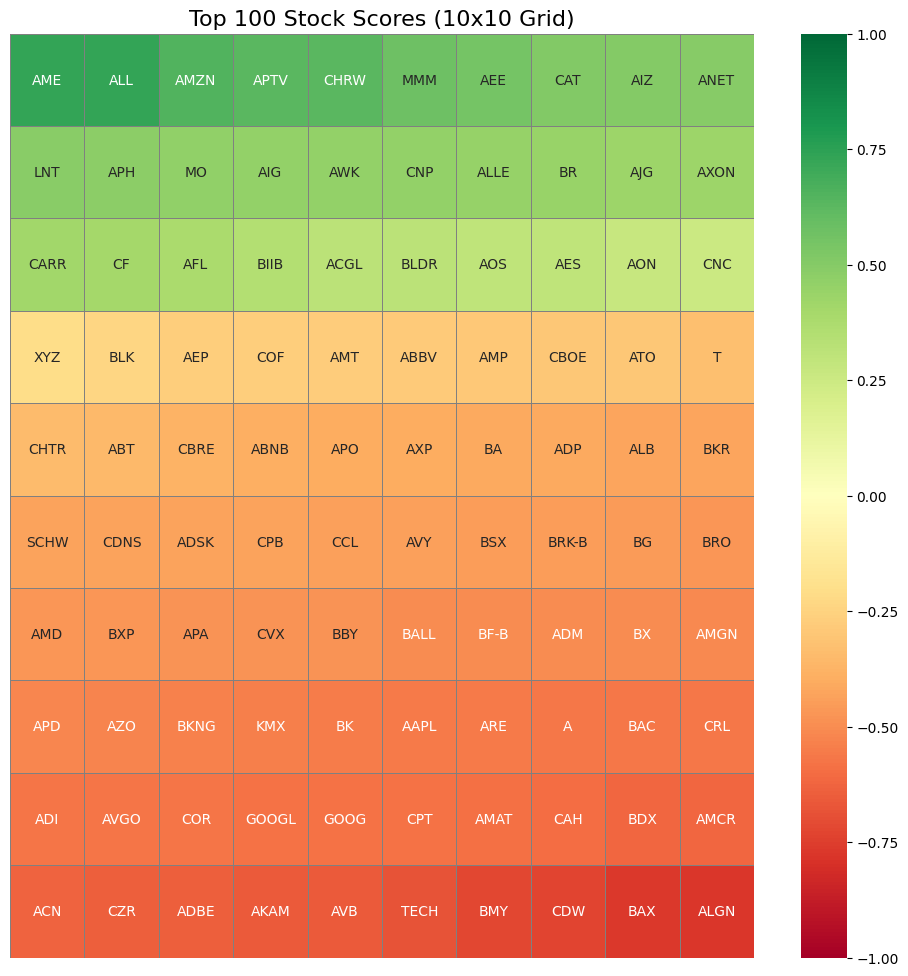

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the scanner_df was created before running this
if 'scanner_df' in locals() and not scanner_df.empty:
    # 1. Prepare the data: Sort by final_score and take the top 100
    top_stocks = scanner_df.sort_values(by='final_score', ascending=False).head(100)
    # top_stocks =scanner_df
    # 2. Extract scores and ticker labels
    scores = top_stocks['final_score'].values
    labels = top_stocks['ticker'].values

    # 3. Pad the data to ensure it's a full 10x10 grid (100 items)
    #    This is crucial if you have fewer than 100 stocks.
    num_items = len(scores)
    padding_needed = 100 - num_items
    
    # Pad scores with np.nan so they appear as blank cells
    padded_scores = np.pad(scores, (0, padding_needed), 'constant', constant_values=np.nan)
    # Pad labels with empty strings
    padded_labels = np.pad(labels, (0, padding_needed), 'constant', constant_values='')

    # 4. Reshape the data into a 10x10 matrix for the heatmap
    scores_matrix = padded_scores.reshape(10, 10)
    labels_matrix = padded_labels.reshape(10, 10)

    # 5. Create the heatmap
    plt.figure(figsize=(12, 12))
    sns.heatmap(
        scores_matrix,
        annot=labels_matrix, # Use the ticker names as labels
        fmt='s',             # Treat annotations as strings
        cmap='RdYlGn',       # Red-Yellow-Green colormap is great for scores
        vmin=-1,             # Set the color scale minimum to -1
        vmax=1,              # Set the color scale maximum to 1
        linewidths=.5,
        linecolor='gray',
        cbar=True            # Show the color bar legend
    )

    # 6. Clean up the plot
    plt.title('Top 100 Stock Scores (10x10 Grid)', fontsize=16)
    plt.xticks([]) # Remove x-axis ticks and labels
    plt.yticks([]) # Remove y-axis ticks and labels
    plt.show()

else:
    print("Cannot generate heatmap because scanner_df is not defined or is empty.")
    print("Please ensure the code that generates 'scanner_df' has been run successfully.")



In [4]:
import pandas as pd
import requests
import io

# URL to the official Nifty 100 constituents CSV file from the NSE archives
url = 'https://archives.nseindia.com/content/indices/ind_nifty100list.csv'

# Set headers to mimic a browser request, which can help avoid being blocked
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

try:
    # Send a GET request to the URL with the specified headers
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # Raise an exception for bad status codes (like 404 or 500)

    # Read the CSV content from the response into a pandas DataFrame
    # io.StringIO allows reading the string content as if it were a file
    nifty100_df = pd.read_csv(io.StringIO(response.content.decode('utf-8')))

    # Extract the 'Symbol' column into a Python list
    nifty100_list = nifty100_df['Symbol'].tolist()

    # --- Important for yfinance ---
    # Add the '.NS' suffix to each ticker for use with yfinance
    nifty100_list_for_yfinance = [ticker + '.NS' for ticker in nifty100_list]


    # Display the first 10 tickers from the final list as an example
    print("Successfully fetched the Nifty 100 list.")
    print("First 10 tickers (ready for yfinance):")
    print(nifty100_list_for_yfinance)

except requests.exceptions.RequestException as e:
    print(f"Error fetching data from NSE: {e}")



Successfully fetched the Nifty 100 list.
First 10 tickers (ready for yfinance):
['ABB.NS', 'ADANIENSOL.NS', 'ADANIENT.NS', 'ADANIGREEN.NS', 'ADANIPORTS.NS', 'ADANIPOWER.NS', 'AMBUJACEM.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'DMART.NS', 'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BAJAJHLDNG.NS', 'BAJAJHFL.NS', 'BANKBARODA.NS', 'BEL.NS', 'BPCL.NS', 'BHARTIARTL.NS', 'BOSCHLTD.NS', 'BRITANNIA.NS', 'CGPOWER.NS', 'CANBK.NS', 'CHOLAFIN.NS', 'CIPLA.NS', 'COALINDIA.NS', 'DLF.NS', 'DABUR.NS', 'DIVISLAB.NS', 'DRREDDY.NS', 'EICHERMOT.NS', 'ETERNAL.NS', 'GAIL.NS', 'GODREJCP.NS', 'GRASIM.NS', 'HCLTECH.NS', 'HDFCBANK.NS', 'HDFCLIFE.NS', 'HAVELLS.NS', 'HEROMOTOCO.NS', 'HINDALCO.NS', 'HAL.NS', 'HINDUNILVR.NS', 'HYUNDAI.NS', 'ICICIBANK.NS', 'ICICIGI.NS', 'ICICIPRULI.NS', 'ITC.NS', 'INDHOTEL.NS', 'IOC.NS', 'IRFC.NS', 'INDUSINDBK.NS', 'NAUKRI.NS', 'INFY.NS', 'INDIGO.NS', 'JSWENERGY.NS', 'JSWSTEEL.NS', 'JINDALSTEL.NS', 'JIOFIN.NS', 'KOTAKBANK.NS', 'LTIM.NS', 'LT.NS', 'LICI.NS', 'LODH